# Bayesian networks

We use the [pgmpy](https://pgmpy.org/) library to create and manipulate the following Bayesian network.

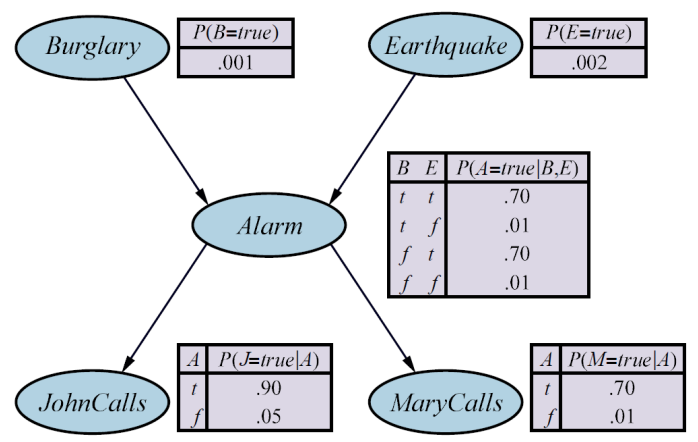

In [1]:
# %pip install -q pgmpy
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from itertools import product
from tabulate import tabulate

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


In [2]:
# Defining the model structure- by just passing a list of edges
alarm_model = DiscreteBayesianNetwork(
    [
        ("Burglary", "Alarm"),
        ("Earthquake", "Alarm"),
        ("Alarm", "JohnCalls"),
        ("Alarm", "MaryCalls"),
    ]
)

# parameters using CPT
cpd_burglary = TabularCPD(
    variable="Burglary", variable_card=2, values=[[0.999], [0.001]]
)
cpd_earthquake = TabularCPD(
    variable="Earthquake", variable_card=2, values=[[0.998], [0.002]]
)
cpd_alarm = TabularCPD(
    variable="Alarm",
    variable_card=2,
    values=[
        [0.999, 0.71, 0.06, 0.05], 
        [0.001, 0.29, 0.94, 0.95]
        ],
    evidence=["Burglary", "Earthquake"],
    evidence_card=[2, 2],
)
cpd_johncalls = TabularCPD(
    variable="JohnCalls",
    variable_card=2,
    values=[
        [0.95, 0.1], 
        [0.05, 0.9]],
    evidence=["Alarm"],
    evidence_card=[2],
)
cpd_marycalls = TabularCPD(
    variable="MaryCalls",
    variable_card=2,
    values=[
        [0.99, 0.3], 
        [0.01, 0.7]],
    evidence=["Alarm"],
    evidence_card=[2],
)

# Associating the parameters with the model structure
alarm_model.add_cpds(
    cpd_burglary, cpd_earthquake, cpd_alarm, cpd_johncalls, cpd_marycalls
)

# Checking if the cpds are valid for the model
alarm_model.check_model()

True

Note that the CPT are represented differently from the book/slides, but they convey the same information.

In [3]:
print(cpd_johncalls)

+--------------+----------+----------+
| Alarm        | Alarm(0) | Alarm(1) |
+--------------+----------+----------+
| JohnCalls(0) | 0.95     | 0.1      |
+--------------+----------+----------+
| JohnCalls(1) | 0.05     | 0.9      |
+--------------+----------+----------+


In [4]:
print(cpd_alarm)

+------------+---------------+---------------+---------------+---------------+
| Burglary   | Burglary(0)   | Burglary(0)   | Burglary(1)   | Burglary(1)   |
+------------+---------------+---------------+---------------+---------------+
| Earthquake | Earthquake(0) | Earthquake(1) | Earthquake(0) | Earthquake(1) |
+------------+---------------+---------------+---------------+---------------+
| Alarm(0)   | 0.999         | 0.71          | 0.06          | 0.05          |
+------------+---------------+---------------+---------------+---------------+
| Alarm(1)   | 0.001         | 0.29          | 0.94          | 0.95          |
+------------+---------------+---------------+---------------+---------------+


## State probabilities

In [5]:
alarm_model.get_state_probability({"Alarm": True, "Burglary": False, "Earthquake": False, "JohnCalls": True, "MaryCalls": True})

0.0006281112599999999

In [6]:
alarm_model.get_state_probability({"Alarm": 1, "Burglary": 0, "Earthquake": 0, "JohnCalls": 1, "MaryCalls": 1})

0.0006281112599999999

In [7]:
alarm_model.get_state_probability({"Alarm": 1, "Burglary": 1, "Earthquake": 0, "JohnCalls": 0, "MaryCalls": 1})

6.56684e-05

In [8]:
alarm_model.get_state_probability({"Alarm": 1})

0.002516442

## Independences

In [9]:
# Checking independcies of a node
alarm_model.local_independencies("Burglary")

(Burglary ⟂ Earthquake)

In [10]:
# Listing all Independencies
alarm_model.get_independencies()

(Earthquake ⟂ MaryCalls | Alarm)
(JohnCalls ⟂ MaryCalls | Alarm)
(Earthquake ⟂ Burglary)
(JohnCalls ⟂ Burglary | Alarm)
(MaryCalls ⟂ Burglary | Alarm)
(Earthquake ⟂ JohnCalls | Alarm)

## Represent the full joint distribution


In [11]:
table = [["Alarm", "Burglary", "Earthquake", "JohnCalls", "MaryCalls", "P"]]
for a, b, e, j, m in product([0, 1], repeat=5):
    prob = alarm_model.get_state_probability({'Alarm': a, 'Burglary': b, 'Earthquake': e, 'JohnCalls': j, 'MaryCalls': m})
    table.append([a, b, e, j, m, prob])
print(tabulate(table[1:], headers=table[0]))

  Alarm    Burglary    Earthquake    JohnCalls    MaryCalls            P
-------  ----------  ------------  -----------  -----------  -----------
      0           0             0            0            0  0.936743
      0           0             0            0            1  0.00946205
      0           0             0            1            0  0.0493022
      0           0             0            1            1  0.000498002
      0           0             1            0            0  0.00133417
      0           0             1            0            1  1.34765e-05
      0           0             1            1            0  7.02197e-05
      0           0             1            1            1  7.0929e-07
      0           1             0            0            0  5.63171e-05
      0           1             0            0            1  5.6886e-07
      0           1             0            1            0  2.96406e-06
      0           1             0            1            1 

In [12]:
sum(row[-1] for row in table[1:])

0.9999999999999998

In [13]:
sum(row[-1] for row in table[1:]) == 1

False

In [14]:
import numpy
numpy.isclose(sum(row[-1] for row in table[1:]), 1)

True

## Inference

In [15]:
from pgmpy.inference import VariableElimination

alarm_infer = VariableElimination(alarm_model)

In [16]:
q = alarm_infer.query(
    variables=["Burglary"], 
    evidence={"JohnCalls": 1, "MaryCalls": 1}
)
print(q)

+-------------+-----------------+
| Burglary    |   phi(Burglary) |
+=============+=================+
| Burglary(0) |          0.7158 |
+-------------+-----------------+
| Burglary(1) |          0.2842 |
+-------------+-----------------+


In [17]:
q = alarm_infer.query(
    variables =["Alarm"],
    evidence={"JohnCalls": 1, "MaryCalls": 1}
)
print(q)

+----------+--------------+
| Alarm    |   phi(Alarm) |
+==========+==============+
| Alarm(0) |       0.2393 |
+----------+--------------+
| Alarm(1) |       0.7607 |
+----------+--------------+


In [18]:
q = alarm_infer.query(
    variables =["JohnCalls"],
    evidence={"Burglary": 1}
)
print(q)

+--------------+------------------+
| JohnCalls    |   phi(JohnCalls) |
+==============+==================+
| JohnCalls(0) |           0.1510 |
+--------------+------------------+
| JohnCalls(1) |           0.8490 |
+--------------+------------------+


## Simulation

In [19]:
alarm_model.simulate(10, evidence={"Alarm": 1})

  0%|          | 0/10 [00:00<?, ?it/s]

,Earthquake,JohnCalls,Alarm,MaryCalls,Burglary
0,0,1,1,1,1
1,0,1,1,1,1
2,0,1,1,1,1
3,1,1,1,1,0
4,0,1,1,1,1
5,0,0,1,1,0
6,0,1,1,1,0
7,0,1,1,1,0
8,1,1,1,0,0
9,0,1,1,1,1
